# Automatic loan word extraction for early modern Dutch

Author: Lucas van der Deijl, University of Amsterdam  
Version: 20 December 2019  
Contact: l.a.vanderdeijl@uva.nl, www.lucasvanderdeijl.nl  
Project: 'Radical Rumours' (Funded by NWO 2017-2021)  

## Aim of this program

The aim of this program is to partly automate the analysis of foreign terminology in early modern Dutch texts. It extracts all loan words from a corpus based on three seventeenth-century loan word dictionaries comprising a lexicon of 10,457 distinct loan words.

## Pipeline
The pipeline desigend to achieve the program's aim performs the following steps:

<ul>
    <li>Import the required libraries</li>
    <li>Install the required libraries (if needed)</li>
    <li>Convert lemmatised Folia-files to .txt (if needed)</li>
    <li>Define corpus and create outputfiles</li>
    <li>Extract all loan words from each document in the corpus</li>
    <li>Visualise most frequent loan words in the corpus</li>
</ul>

## Required pre-processing

This program assumes lemmatised Folia-files (xml) as input. You can use the Dutch POS-tagging software FROG (available through <a href="https://proycon.github.io/LaMachine/">LaMachine</a> or the <a href="http://portal.clarin.nl/node/14392">PICCL</a> framework supported by CLARIN) to tokenise and lemmatise your corpus. Save the .xml-files generated by FROG into the folder 'Folia_files'. If you would like to work with lemmatised .txt-files as input right away, then you can store the files in the folder Corpus (as .txt-files with character encoding UTF-8). 

You can also extract loan words from non-lemmatised input, but this will result in lower recall scores. Please note that FROG was developed for Modern Dutch and spelling variation in early modern Dutch causes errors in the lemmatisation process. Based on manual annotation of 15,245 word lemmas from 6 sample texts, the recall was estimated at 0.83. 

## Resources

This program uses three seventeenth-century loan word dictionaries to construct a lexicon of 10,457 distinct loan words: Johan Hofman's <a href="https://dbnl.org/tekst/hofm005nede02_01/index.php">*Nederlandtsche woorden-schat*</a> (1650),  Adriaan Koerbagh's <a href="https://dbnl.org/tekst/koer001bloe01_01/index.php">*Een bloemhof van allerley lieflijkheyd sonder verdriet*</a> (1668), and the fifth reprint (1669) of Lodewijk Meijer's re-edition of Hofman's <a href="https://dbnl.org/tekst/meij001lmei01_01/">*Woorden-schat*</a>. Early modern dictionaries are used as a standard because they conveniently take away the need to define and classify loan words anachronistically. There is a strong relation between the three dictionaries: Koerbagh based his dictionary in part on Hofman's and Meijer's dictionaries. For more information on the construction and composition of these dictionaries and their relation to other lexicographers, see: 
<ul>
    <li>Leeuwenburgh, B., Het noodlot van een ketter. Adriaan Koerbagh 1633-1669. Nijmegen: Vantilt 2013.</li>
    <li>Hardeveld–Kooi, I., Lodewijk Meijer (1629-1681) als lexicograaf. Leiden: Dissertation Leiden University 2000.</li>
    <li>Salverda de Grave, J.J., De Franse woorden in het Nederlands. Verhandelingen der Koninklijke akademie van wetenschappen te Amsterdam, afd. Letterkunde. Nieuwe reeks deel VII. Amsterdam 1906.</li>
</ul>



## Import the required libraries

First, the required libaries and resources need to be imported.

In [1]:
import nltk.data
import folia.main as folia
import sys
import os
import string
import csv
import matplotlib.pyplot as plt

tokenizer = nltk.data.load('tokenizers/punkt/dutch.pickle')

## Install the required libraries (if needed)

In case you got an error after the previous step because not all of the required modules are installed, you can uncomment (remove the '#') the relevant install-command below and run the code. Once the module is installed, run the block above again to import it before moving on to the next step

In [42]:
#!pip install nltk
#!pip install folia

## Convert lemmatised Folia-files to .txt (if needed)

The code block below can be used to extract the lemmatised word variants from the enriched Folia files generated by FROG, effectively converting the .xml-files to the required .txt-format. It assumes the Folia files to be stored in the 'Folia_files' folder and stores the converted files in the 'Corpus' folder.

In [12]:
filenames = list(os.listdir("Folia_files"))
for filename in filenames:
    inputfile = ("Folia_files/" + filename)
    outputfile = open(("Corpus/" + filename[:-4] + ".txt"), 'w', encoding="UTF-8")
    doc = folia.Document(file = inputfile)
    lemmatised_list = []
    for word in doc.words():
        lemma = word.annotation(folia.LemmaAnnotation)
        pos = word.annotation(folia.PosAnnotation)
        lemmatised_list.append(lemma.cls)
    lemmatised_doc = ' '.join(lemmatised_list)
    outputfile.write(lemmatised_doc)
    outputfile.close()
    print(filename, "stored as .txt-file in Corpus-folder")
print("All files from Folia_files converted and stored in Corpus-folder")

Descartes_Copper_BML_1682_normalised.frogged.folia.xml stored as .txt-file in Corpus-folder
Descartes_Copper_VvdM_1682_normalised.frogged.folia.xml stored as .txt-file in Corpus-folder
All files from Folia_files converted and stored in Corpus-folder


## Define corpus and create outputfiles

In [13]:
corpus = os.listdir("Corpus\\")	
main_outputfile = open(("Output\main_outputfile.txt"), 'w', encoding="UTF-8")
loanwords_indexfile = open(("Output\loanwords_in_corpus.txt"), 'w', encoding="UTF-8")
loanwords_corpusdict = {}
headers_outputfile = "Filename;Tokens;Types;Loanwords Hofman (types);Loanwords Koerbagh (types);Loanwords Meijer (types);Purist words Hofman (types);Purist words Koerbagh (types);Purist words Meijer (types);Loanwords Hofman (tokens);Loanwords Koerbagh (tokens);Loanwords Meijer (tokens);Purist words Hofman (tokens);Purist words Koerbagh (tokens);Purist words Meijer (tokens);All loanwords (types); All purist words (types);All loanwords (tokens); All purist words (tokens);All loanwords Hofman (index);All loanwords Koerbagh (index);All loanwords Meijer (index);All purist words Hofman (index);All purist words Koerbagh (index);All purist words Meijer (index) \n"
main_outputfile.write(headers_outputfile)

640

## Parse the three loan word dictionaries

The code below parses the three dictionaries and stores all entries in separate lists, one for loan words and one for their purist equivalents.

In [14]:
Hofmanfile = open("Resources\Hofman_Woordenschat_1650.csv", "r", newline="", encoding="UTF-8")       
rows_in_Hofmanfile = list(csv.reader(Hofmanfile, delimiter=';', quotechar='|'))
loan_words_Hofman = []
purist_words_Hofman = []

Koerbaghfile = open("Resources\Koerbagh_Bloemhof_1668.csv", "r", newline="", encoding="UTF-8")       
rows_in_Koerbaghfile = list(csv.reader(Koerbaghfile, delimiter=';', quotechar='|'))
loan_words_Koerbagh = []
purist_words_Koerbagh = []

Meijerfile = open("Resources\Meijer_Woordenschat_1669.csv", "r", newline="", encoding="UTF-8")       
rows_in_Meijerfile = list(csv.reader(Meijerfile, delimiter=';', quotechar='|'))
loan_words_Meijer = []
purist_words_Meijer = []

for row in rows_in_Hofmanfile:
    loan_word = row[0]
    list_of_purisms = row[1].split(',')
    loan_words_Hofman.append(loan_word)

    for purism in list_of_purisms:
        if purism not in purist_words_Hofman:
            purist_words_Hofman.append(purism)

print(len(loan_words_Hofman), "loan words extraced from Hofman's dictionary")
print(len(purist_words_Hofman), "purist words extraced from Hofman's dictionary")

for row in rows_in_Koerbaghfile:
    loan_word = row[0]
    list_of_purisms = row[1].split(',')
    loan_words_Koerbagh.append(loan_word)

    for purism in list_of_purisms:
        if purism not in purist_words_Koerbagh:
            purist_words_Koerbagh.append(purism)

print(len(loan_words_Koerbagh), "loan words extraced from Koerbagh's dictionary")
print(len(purist_words_Koerbagh), "purist words extraced from Koerbagh's dictionary")

for row in rows_in_Meijerfile:
    loan_word = row[0]
    list_of_purisms = row[1].split(',')
    loan_words_Meijer.append(loan_word)

    for purism in list_of_purisms:
        if purism not in purist_words_Meijer:
            purist_words_Meijer.append(purism)

print(len(unique_meijer), "loan words copied by Koerbagh from Meijer")        
print(len(loan_words_Meijer), "loan words extraced from Meijer's dictionary")
print(len(purist_words_Meijer), "purist words extraced from Meijer's dictionary")
print(len(list(set(loan_words_Koerbagh + loan_words_Hofman + loan_words_Meijer))), "distinct loan words extracted from all dictionaries")

3749 loan words extraced from Hofman's dictionary
5146 purist words extraced from Hofman's dictionary
8454 loan words extraced from Koerbagh's dictionary
16373 purist words extraced from Koerbagh's dictionary
2650 loan words copied by Koerbagh from Meijer
7315 loan words extraced from Meijer's dictionary
12836 purist words extraced from Meijer's dictionary
10457 distinct loan words extracted from all dictionaries


## Extract all loan words from each document in the corpus

The following block parses each text in the corpus and converts their content into lists of lowercase tokens. Subsequently, it tries to match all distinct lemmas from each document against all entries from the three dictionaries. For each document from the corpus it saves a separate file with all loan words and their purist equivalent in the directory 'Output\outputfiles'. Additionally, it saves several counts and descriptive statistics in a general outputfile 'main_outputfile.txt' (number of tokens, number of types, number of loan word types, number of loan word tokens etc.).

In [15]:
for doc in corpus:
    filename = doc[:-4]
    text = open(("Corpus\\" + doc), encoding="UTF-8")
    clean_text = text.read().lower().translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(clean_text)
    types = list(set(tokens))

    # Create two lists and count and store all loan words and purisms as defined by the dictionary
    loan_words_text_Hofman = []
    purist_words_text_Hofman = []
    loanwordcount_Hofman = {}
    puristwordcount_Hofman = {}

    loan_words_text_Koerbagh = []
    purist_words_text_Koerbagh = []
    loanwordcount_Koerbagh = {}
    puristwordcount_Koerbagh = {}
    
    loan_words_text_Meijer = []
    purist_words_text_Meijer = []
    loanwordcount_Meijer = {}
    puristwordcount_Meijer = {}

    outputfile_all_loanwords = open(("Output\outputfiles\\" + filename + "_all_loanwords.txt"), 'w', encoding="UTF-8")
    outputfile_all_purisms = open(("Output\outputfiles\\" + filename + "_all_purisms.txt"), 'w', encoding="UTF-8")

    for word in types:
        if word in loan_words_Koerbagh:
            loan_words_text_Koerbagh.append(word)
            loanwordcount_Koerbagh[word] = tokens.count(word)
        if word in loan_words_Hofman:
            loan_words_text_Hofman.append(word)
            loanwordcount_Hofman[word] = tokens.count(word)
        if word in loan_words_Meijer:
            loan_words_text_Meijer.append(word)
            loanwordcount_Meijer[word] = tokens.count(word)
            
        if word in purist_words_Koerbagh:
            purist_words_text_Koerbagh.append(word)
            puristwordcount_Koerbagh[word] = tokens.count(word)
        if word in purist_words_Hofman:
            purist_words_text_Hofman.append(word)
            puristwordcount_Hofman[word] = tokens.count(word)
        if word in purist_words_Meijer:
            purist_words_text_Meijer.append(word)
            puristwordcount_Meijer[word] = tokens.count(word)

    
    all_loanwords = {**loanwordcount_Hofman, **loanwordcount_Koerbagh, **loanwordcount_Meijer}
    all_puristwords = {**puristwordcount_Hofman, **puristwordcount_Koerbagh, **puristwordcount_Meijer}

    i = 0
    for k,v in sorted(all_loanwords.items(), key=lambda all_loanwords: all_loanwords[1], reverse=True):
        i += 1
        if k not in loanwords_corpusdict:
            loanwords_corpusdict[k] = v
        else: 
            loanwords_corpusdict[k] += v
        table_row = '%d, %s, %d \n' % (i, k, v)
        outputfile_all_loanwords.write(table_row)

    i = 0  	
    for k,v in sorted(all_puristwords.items(), key=lambda all_puristwords: all_puristwords[1], reverse=True):
        i += 1
        table_row = '%d, %s, %d \n' % (i, k, v)
        outputfile_all_purisms.write(table_row)

    outputline = "%s;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%d;%s;%s;%s;%s;%s;%s  \n" % (filename, len(tokens), len(types), len(loan_words_text_Hofman), len(loan_words_text_Koerbagh), len(loan_words_text_Meijer), len(purist_words_text_Hofman), len(purist_words_text_Koerbagh), len(purist_words_text_Meijer), sum(loanwordcount_Hofman.values()), sum(loanwordcount_Koerbagh.values()), sum(loanwordcount_Meijer.values()), sum(puristwordcount_Hofman.values()), sum(puristwordcount_Koerbagh.values()), sum(puristwordcount_Meijer.values()), len(all_loanwords.keys()), len(all_puristwords.keys()), sum(all_loanwords.values()), sum(all_puristwords.values()), str(loan_words_text_Hofman), str(loan_words_text_Koerbagh), str(loan_words_text_Meijer), str(purist_words_text_Hofman), str(purist_words_text_Koerbagh), str(purist_words_text_Meijer))
    main_outputfile.write(outputline)
    print("Data stored in main outputfile for", filename)
    text.close()
    outputfile_all_loanwords.close()
    outputfile_all_purisms.close()
i = 0
for k,v in sorted(loanwords_corpusdict.items(), key=lambda loanwords_corpusdict: loanwords_corpusdict[1], reverse=True):
    i += 1
    table_row = '%d, %s, %d \n' % (i, k, v)
    loanwords_indexfile.write(table_row)

print(len(loanwords_corpusdict), "loan words stored in indexfile")
main_outputfile.close()
loanwords_indexfile.close()
Hofmanfile.close()
Koerbaghfile.close()
Meijerfile.close()

Data stored in main outputfile for Descartes_Copper_BML_1682_normalised.frogged.folia
Data stored in main outputfile for Descartes_Copper_VvdM_1682_normalised.frogged.folia
67 loan words stored in indexfile


## Visualise most frequent loan words in corpus

The visualisation below displays the most frequent loan words in the corpus. The plot will be stored as a .png-file in the Output-directory of this notebook. You can change the title of the graph in the code below.

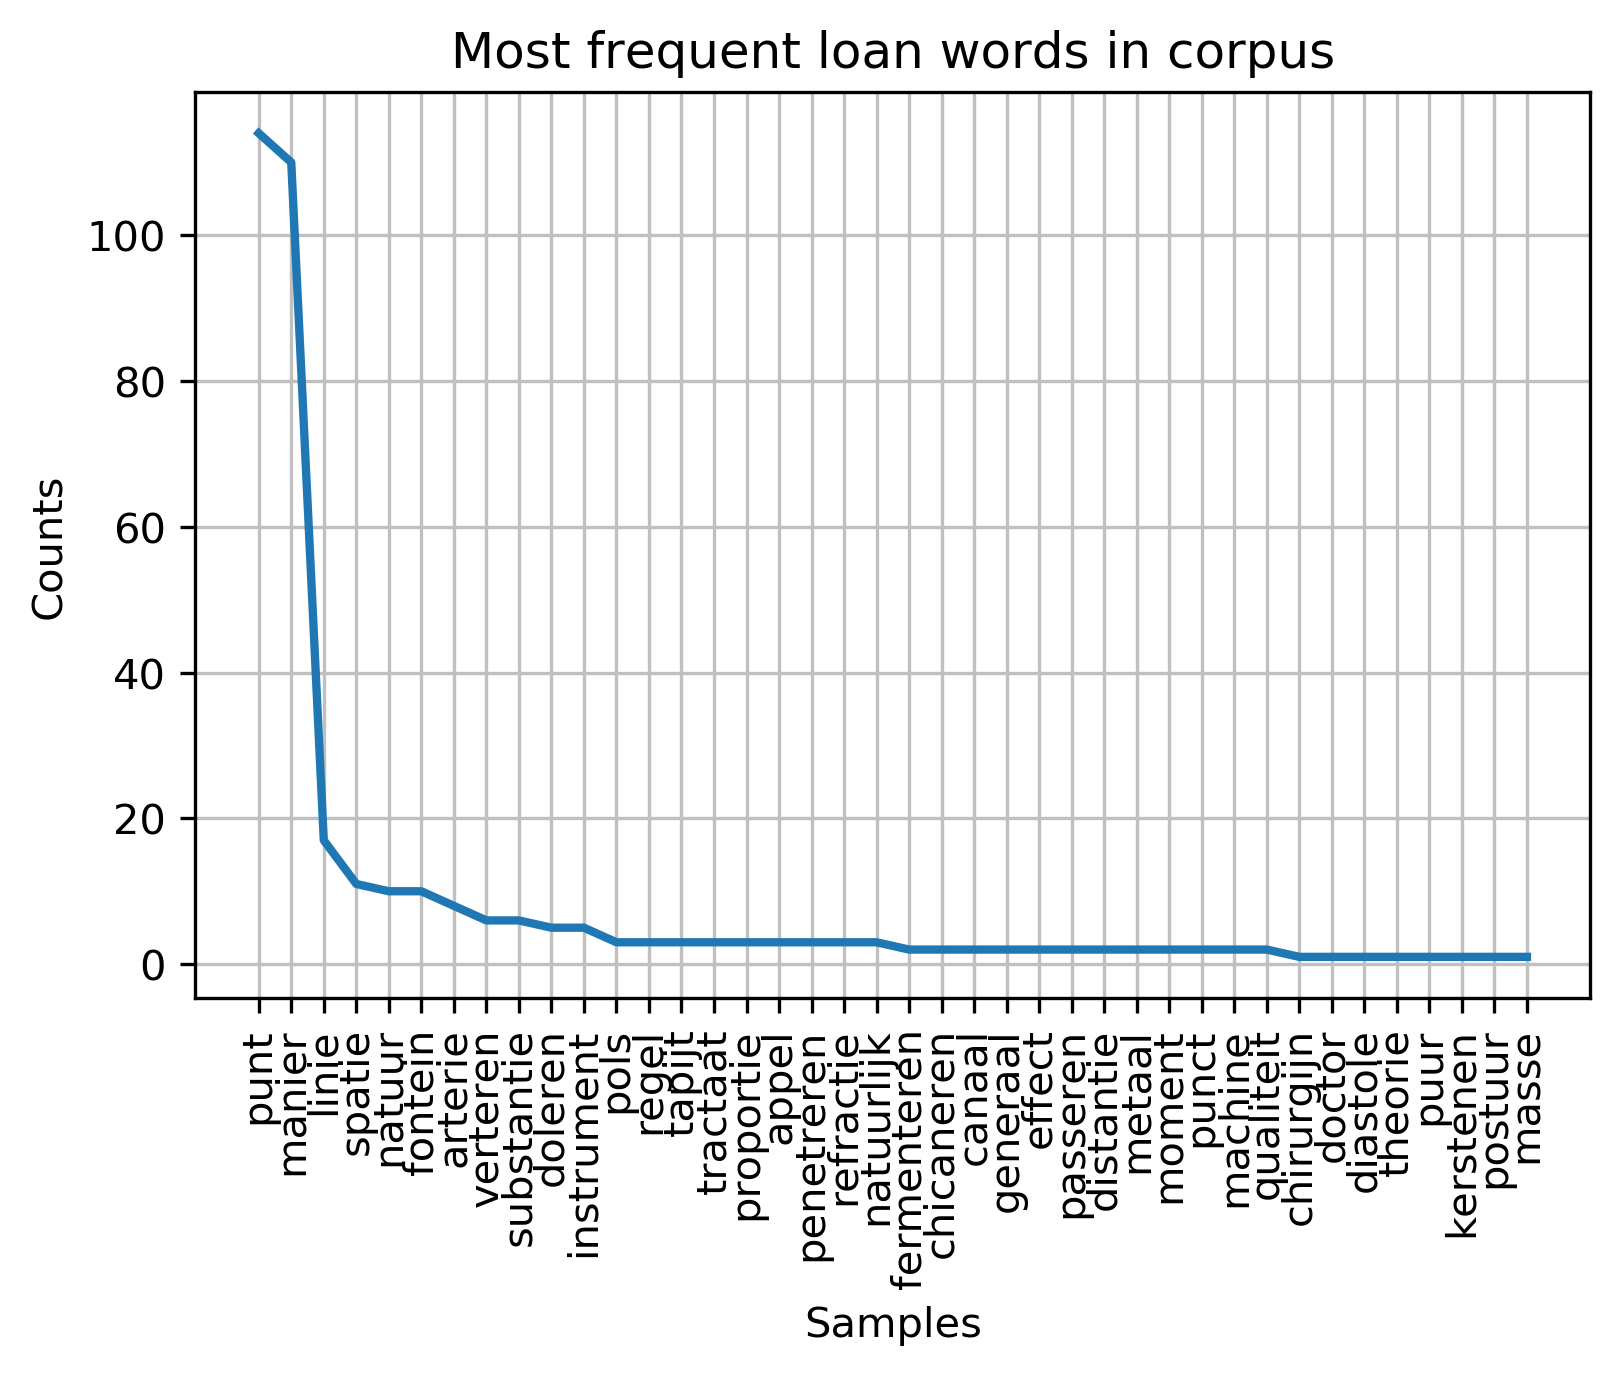

In [16]:
all_loanwords = [loanword for loanword in loanwords_corpusdict]
freq_dist = nltk.FreqDist(loanwords_corpusdict)
fig = plt.figure(figsize=(6,4), dpi=300)
freq_dist.plot(40,title="Most frequent loan words in corpus")
fig.savefig("Output/most_frequent_loanwords.png", bbox_inches='tight') #save the file
